## Predict Simulations

Workflow for predicting DZ given a model

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import pickle
from scipy.interpolate import interp1d
import imageio.v2 as imageio
from pathlib import Path
import h5py
from scipy.io import savemat
import scipy.integrate as integrate
from skimage import exposure
from skimage import filters
from scipy import stats
from scipy.io import readsav

import torch
import torch.nn as nn
import timm

from plasma_tv.data.file_utils import GetEmission, GetPkl
from plasma_tv.utils.helpers import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# System Identification
Do this after doing weighted_prediction_ml

In [13]:
tv = GetEmission('../data/raw/all')
files = tv.list_files(True)
file_idx = 19
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = tv.load_all(files[file_idx])
shotn = files[file_idx].stem.split('_')[-1]

0 	 189057
1 	 189061
2 	 189062
3 	 189081
4 	 189088
5 	 189090
6 	 189093
7 	 189094
8 	 189097
9 	 189100
10 	 189101
11 	 189448
12 	 189451
13 	 190109
14 	 190110
15 	 190113
16 	 190114
17 	 190115
18 	 190116
19 	 199166
20 	 199171
21 	 199172
22 	 199351
23 	 199352
24 	 199353
25 	 199354
Extracting sav for shot: 199166
Resizing...


In [14]:
# histogram match vid

vid_noisy = noisify(vid)
images_M = vid_noisy.astype(np.float32) / 255.0

target_cdf = np.load('../data/processed/histogram/target_cdf.npy')
bin_edges = np.load('../data/processed/histogram/bin_edges.npy')
vid = match_images_to_histogram(images_M, target_cdf, bin_edges)

In [15]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files(True)

0 	 200970
1 	 200971
2 	 200972
3 	 200973
4 	 200974
5 	 200975
6 	 200976
7 	 200977
8 	 200978
9 	 201072
10 	 201073
11 	 201074
12 	 201075
13 	 201076
14 	 201077
15 	 201078
16 	 201079
17 	 201080
18 	 201081
19 	 201082
20 	 201083
21 	 201084
22 	 201085


In [16]:
# copy the result over to data_fetching on iris
print([int(i.stem.split('_')[-1]) for i in files])

[200970, 200971, 200972, 200973, 200974, 200975, 200976, 200977, 200978, 201072, 201073, 201074, 201075, 201076, 201077, 201078, 201079, 201080, 201081, 201082, 201083, 201084, 201085]


In [17]:
file_idx = 21
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')

Shot 201081


In [18]:
vid, vid_times = tv.load_processed(files[file_idx])
vid_times *= 1e3

In [33]:
h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
print(shot)
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:]
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()]
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()]
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    # lftdz = file[shot]['lftdz'][:]
    # lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]

201081
<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [19]:
vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))
vid_process_3 = normalize_image(vid)[:,::2,::3]
vid_process_3 = np.reshape(vid_process_3, (vid_process_3.shape[0], -1))
vid_process_dl = vid[:,8:232,250:474] / 255 * 2 - 1
vid_process_dl = np.repeat(vid_process_dl[:, np.newaxis, :, :], 3, axis=1)
vid_process_dl = torch.from_numpy(vid_process_dl).float().to(device)

In [34]:
coefficients_file = Path('../models/092324_tangtv_v2.txt')
coefficients_0 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_0.append(float(line.strip()))

coefficients_file = Path('../models/092624_tangtv_v5.txt')
coefficients_1 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_1.append(float(line.strip()))

coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))
        
coefficients_file = Path('../models/weighted_outer_all5_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_3 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_3.append(float(line.strip()))
        
coefficients_file = Path('../models/weighted_outer_all6_coefficients.txt') # outer all 6 is regression + b
coefficients_4 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_4.append(float(line.strip()))
        
# dl_model_path = Path('../models/weighted_dl.pt')
# dl_model = torch.load(dl_model_path,weights_only=False,map_location=torch.device('cpu'))
# dl_model.eval()
# dl_model.to(device)

In [35]:
coef_2_reshape = np.reshape(np.abs(coefficients_2), (vid.shape[1], vid.shape[2])) * 1e7

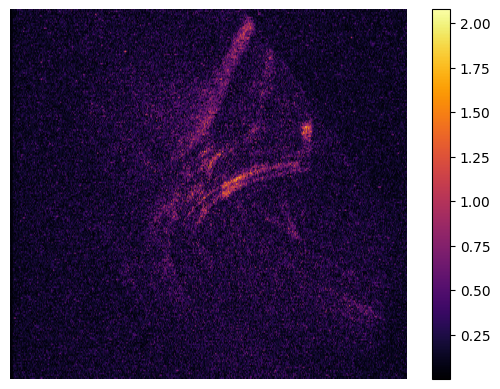

In [36]:
fig, ax = plt.subplots()
img1 = ax.imshow(coef_2_reshape, cmap='inferno')
fig.colorbar(img1, ax=ax)
ax.set_aspect('auto')
ax.axis('off')
plt.show()

In [37]:
prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614
prediction_3 = np.dot(vid_process_3, coefficients_3) - 1.0928636
# prediction_dl = dl_model(vid_process_dl).cpu().detach().numpy().flatten() / 2 - .6

In [38]:

vid_sum = np.sum(normalize_image(vid)[:,::2,::3], axis=(2))
print(vid_sum.shape)
loc_idx = np.arange(vid_sum.shape[1])
print(loc_idx.shape)
locavgsum = vid_sum * loc_idx
print((locavgsum**2).shape)
vid_avg_loc = np.sqrt(np.sum(locavgsum**2,axis=1)/np.sum(vid_sum**2))
print(vid_avg_loc.shape)

(300, 120)
(120,)
(300, 120)
(300,)


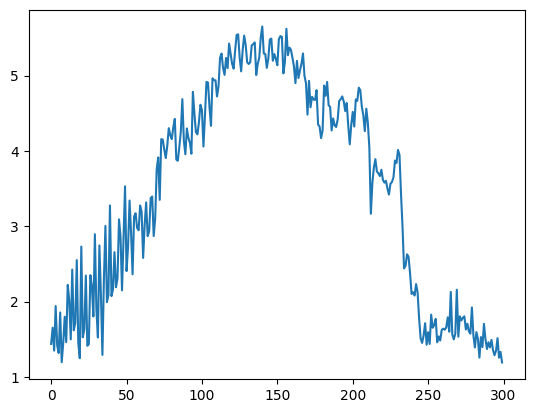

In [39]:
plt.plot(vid_avg_loc)

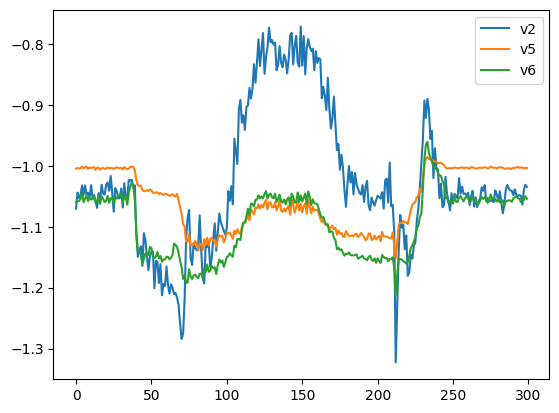

In [40]:
plt.plot(prediction_0, label='v2')
plt.plot(prediction_1, label='v5')
plt.plot(prediction_2, label='v6')
# plt.plot(prediction_3, label='ridge')
# plt.plot(prediction_dl, label='dl')
plt.legend()
plt.show()

In [41]:
t_start = 2000
t_end = 5000#t_ip_flat_sql + ip_flat_duration_sql

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prediction_3 = crop_time(vid_times, prediction_3, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)

interp_kind = 'cubic'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_3 = interp1d(crop_vid_times, crop_prediction_3, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_3 = 1 - ((interp_ZXPT - interp_prediction_3) / (interp_ZXPT - interp_ZStrike))[0]

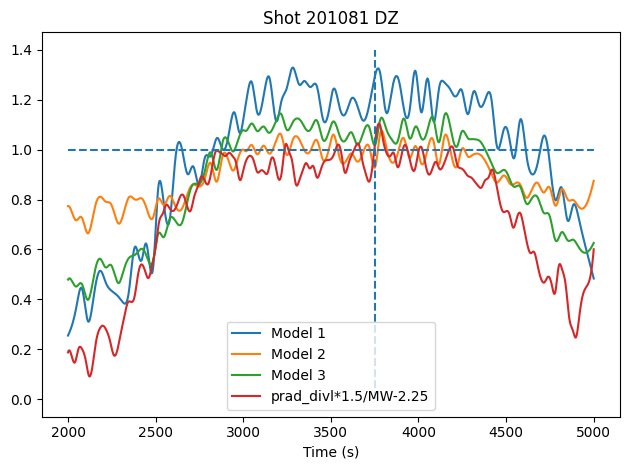

In [43]:
plt.plot(t_grid,Dz_0 / 2,label='Model 1')
plt.plot(t_grid,Dz_1,label='Model 2')
plt.plot(t_grid,Dz_2,label='Model 3')
plt.plot(t_grid,interp_prad_divl*1.5e-6-2.25,label='prad_divl*1.5/MW-2.25')
# plt.plot(t_grid,Dz_3,label='dl')
plt.hlines(1,t_start,t_end,linestyles='dashed')
plt.vlines(3750,0,1.4,linestyles='dashed')
plt.xlabel('Time (s)')
# plt.ylim(0,1.4)
# plt.xlim(t_start,t_end)
plt.legend()
plt.title(f'Shot {shotn} DZ')
plt.tight_layout()
plt.show()

In [20]:
st = 4000
detach_idx = nearest_index(t_grid, [st])
attach_idx = nearest_index(t_grid, [4700])
print(Dz_1[detach_idx], Dz_1[attach_idx])
print(Dz_2[detach_idx], Dz_2[attach_idx])
print(np.mean(Dz_2[detach_idx:attach_idx]))

0.9682219518172779 0.9784148798024848
0.6838981200057783 0.6300757067449472
0.6850363918815301


estimated delay:140


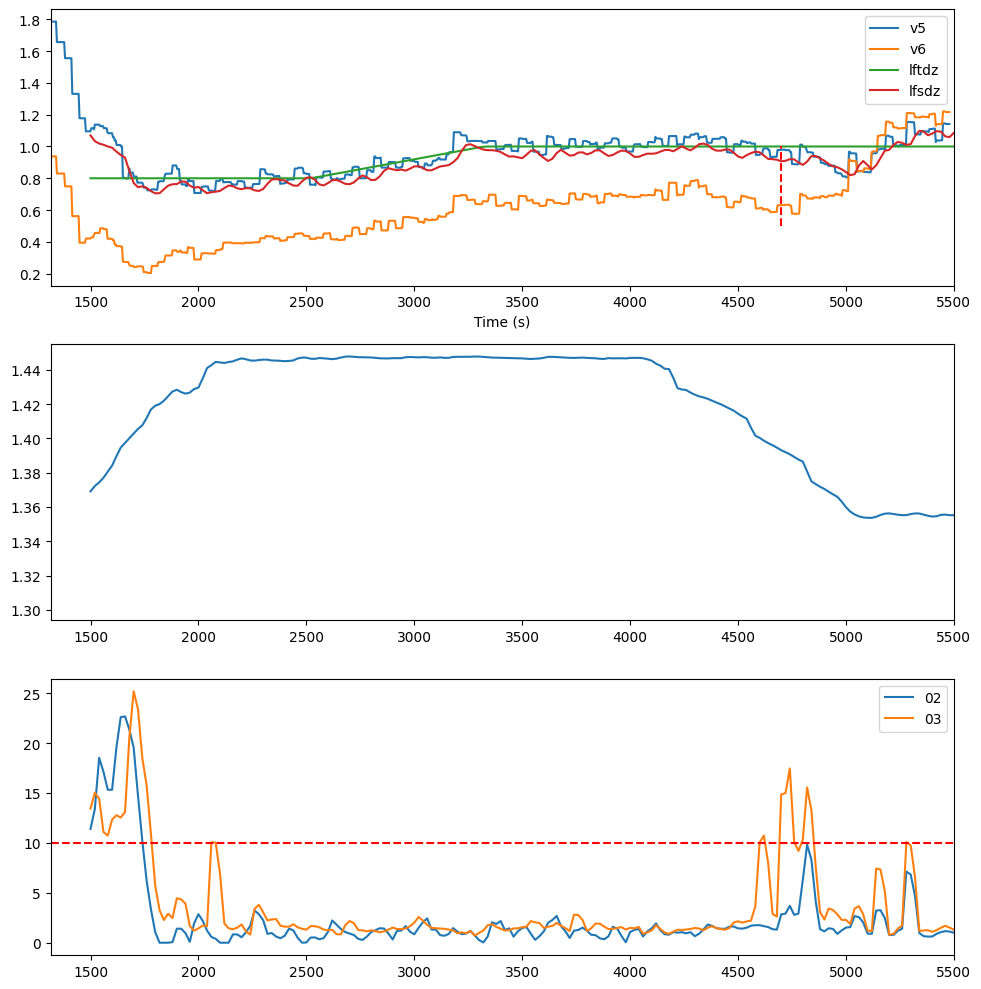

In [21]:
st = 2670
print(f'estimated delay:{2670-2530}')
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(t_grid,Dz_1,label='v5')
plt.plot(t_grid,Dz_2,label='v6')
plt.plot(h5_times,1-lftdz, label='lftdz')
plt.plot(h5_times,1-lfsdz, label='lfsdz')
# plt.vlines([st,st + 1920], .5, 1, color='r', linestyle='--')
plt.vlines([4700], .5, 1, color='r', linestyle='--')
plt.xlim(t_start,t_end)
plt.xlabel('Time (s)')
plt.legend()
plt.subplot(3,1,2)
plt.plot(h5_times, RXPT1_EFIT01)
plt.xlim(t_start,t_end)
plt.subplot(3,1,3)
plt.plot(h5_times, tssdivte02, label='02')
plt.plot(h5_times, tssdivte03, label='03')
plt.xlim(t_start,t_end)
plt.hlines(10, t_start, t_end, color='r', linestyle='--')
# plt.vlines([2530,4450], 0, 20, color='r', linestyle='--')
plt.ylim
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import numpy as np
import h5py
from scipy.interpolate import interp1d
from plasma_tv.data.file_utils import GetEmission, GetPkl
from plasma_tv.utils.helpers import *

from scipy.optimize import curve_fit
from scipy.signal import savgol_filter

In [6]:
irtv_path = Path('../data/external/toksearch/irtv_12_03_2024.pkl')
ir_shot = 13 # 9 for 201081, 12 for 201084, 13 for 201085
irtv_shots = range(201072,201086)
irtv = pickle.load(open(irtv_path, 'rb'))
irtv_data = irtv[ir_shot]
shot, x_ir, t_ir, pos_ir, units_ir = irtv_data
x_ir /= 100
pos_ir /= 100
t_ir /= 1000
print(shot)

201085


In [7]:
t_ir_edges = np.concatenate(([t_ir[0] - (t_ir[1] - t_ir[0]) / 2], 
                                  (t_ir[:-1] + t_ir[1:]) / 2, 
                                  [t_ir[-1] + (t_ir[-1] - t_ir[-2]) / 2]))

pos_ir_edges = np.concatenate(([pos_ir[0] - (pos_ir[1] - pos_ir[0]) / 2], 
                               (pos_ir[:-1] + pos_ir[1:]) / 2, 
                               [pos_ir[-1] + (pos_ir[-1] - pos_ir[-2]) / 2]))

In [8]:
def apply_savitzky_golay_filter(signal, window_length, polyorder):
    # Check if the window length is odd, if not, increment it by 1
    if window_length % 2 == 0:
        window_length += 1
    filtered_signal = savgol_filter(signal, window_length, polyorder)
    return filtered_signal

In [10]:
value_path = Path('../data/processed/') / 'weight_ml_point'
tv = GetPkl('../data/raw/12_03_2024')
files = tv.list_files()
file_idx = 22 # 4: lmode scan rxpt, 18: change zxpt, 21,22: change rxpt
shotn = files[file_idx].stem.split('_')[-1]
print(f'Shot {shotn}')
vid, vid_times = tv.load_processed(files[file_idx])

Number of files: 23
Shot 201085


In [11]:
cbc_colors = {'red':'#dc143c',
           'blue':'#4269e1',
           'olive':'#bfbf00',
    "bk": "#000000",
    "or": "#E69F00",
    "skb": "#56B4E9",
    "gn": "#009E73",
    "yl": "#F0E442",
    "bl": "#0072B2",
    "vn": "#D55E00",
    "rd": "#CC79A7",
    "gn2": "#4daf4a",
    "pk": "#f781bf",
    "bn": "#a65628",
    "gy": "#999999",
}

In [12]:
vid_process_0 = np.reshape(vid, (vid.shape[0], -1))
vid_process_1 = np.reshape(vid, (vid.shape[0], -1))
vid_process_2 = normalize_image(vid)
vid_process_2 = np.reshape(vid_process_2, (vid_process_2.shape[0], -1))

In [13]:
h5_path = '../data/external/toksearch/aps_sig.h5'
shot = str(files[file_idx].stem.split('_')[-1])
with h5py.File(h5_path, 'r') as file:
    
    print(file.keys())
    
    for key in file.keys():
        print(file[key].keys())
        break
    
    h5_times = file['times'][:] / 1000
    t_ip_flat_sql = file[shot]['t_ip_flat_sql'][()] / 1000
    ip_flat_duration_sql = file[shot]['ip_flat_duration_sql'][()] / 1000
    ZXPT1_EFIT01 = file[shot]['ZXPT1_EFIT01'][:]
    RXPT1_EFIT01 = file[shot]['RXPT1_EFIT01'][:]
    tssdivte02 = file[shot]['tssdivte02'][:]
    tssdivte03 = file[shot]['tssdivte03'][:]
    lftdz = file[shot]['lftdz'][:]
    lfsdz = file[shot]['lfsdz'][:]
    prad_divl = file[shot]['dgsraddivl'][:]

<KeysViewHDF5 ['189088', '199166', '200970', '200971', '200972', '200973', '200974', '200975', '200976', '200977', '200978', '201072', '201073', '201074', '201075', '201076', '201077', '201078', '201079', '201080', '201081', '201082', '201083', '201084', '201085', 'spatial_coordinates', 'times']>
<KeysViewHDF5 ['D_tot', 'RXPT1_EFIT01', 'ZXPT1_EFIT01', 'gasA', 'gas_sql', 'ip_flat_duration_sql', 'pinj', 't_ip_flat_sql', 'tinj', "tssdivte00'", 'tssdivte01', 'tssdivte02', 'tssdivte03', 'tssdivte04', 'tssdivte05', 'valve_sql']>


In [14]:
coefficients_file = Path('../models/092324_tangtv_v2.txt')
coefficients_0 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_0.append(float(line.strip()))

coefficients_file = Path('../models/092624_tangtv_v5.txt')
coefficients_1 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_1.append(float(line.strip()))

coefficients_file = Path('../models/weighted_outer_all2_coefficients.txt') # outer all 2 is v6, all 5 is ridge
coefficients_2 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_2.append(float(line.strip()))
        
coefficients_file = Path('../models/weighted_outer_all6_coefficients.txt')
coefficients_3 = []
with open(coefficients_file, 'r') as f:
    for line in f:
        coefficients_3.append(float(line.strip()))

In [15]:
prediction_0 = np.dot(vid_process_0, coefficients_0) - 1.1381
prediction_1 = np.dot(vid_process_1, coefficients_1) - 0.916314
prediction_2 = np.dot(vid_process_2*255, coefficients_2) - 1.098614
prediction_3 = np.dot(vid_process_2*255, coefficients_3[:-1]) - 1.0171065 # replace with num

In [16]:
t_start = 1
t_end = 6 #t_ip_flat_sql + ip_flat_duration_sql

t_grid = np.linspace(t_start, t_end, 1000)
crop_h5_times, crop_ZXPT1_EFIT01 = crop_time(h5_times, ZXPT1_EFIT01, t_start, t_end)
_, crop_RXPT1_EFIT01 = crop_time(h5_times, RXPT1_EFIT01, t_start, t_end)
crop_vid_times, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_0 = crop_time(vid_times, prediction_0, t_start, t_end)
_, crop_prediction_1 = crop_time(vid_times, prediction_1, t_start, t_end)
_, crop_prediction_2 = crop_time(vid_times, prediction_2, t_start, t_end)
_, crop_prediction_3 = crop_time(vid_times, prediction_3, t_start, t_end)
_, crop_prad_divl = crop_time(h5_times, prad_divl, t_start, t_end)
_, crop_lftdz = crop_time(h5_times, lftdz, t_start, t_end)
_, crop_lfsdz = crop_time(h5_times, lfsdz, t_start, t_end)

interp_kind = 'next'
interp_ZXPT = interp1d(crop_h5_times, crop_ZXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_RXPT = interp1d(crop_h5_times, crop_RXPT1_EFIT01, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_0 = interp1d(crop_vid_times, crop_prediction_0, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_1 = interp1d(crop_vid_times, crop_prediction_1, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_2 = interp1d(crop_vid_times, crop_prediction_2, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prediction_3 = interp1d(crop_vid_times, crop_prediction_3, kind=interp_kind, fill_value='extrapolate')(t_grid)
interp_prad_divl = interp1d(crop_h5_times, crop_prad_divl, kind=interp_kind, fill_value='extrapolate')(t_grid)[0]
interp_lfsdz = interp1d(crop_h5_times, crop_lfsdz, kind=interp_kind, fill_value='extrapolate')(t_grid)

# gasA_PID = interp_gasA[0]
interp_ZStrike = np.ones_like(interp_ZXPT) * -1.24477
Dz_0 = 1 - ((interp_ZXPT - interp_prediction_0) / (interp_ZXPT - interp_ZStrike))[0]
Dz_1 = 1 - ((interp_ZXPT - interp_prediction_1) / (interp_ZXPT - interp_ZStrike))[0]
Dz_2 = 1 - ((interp_ZXPT - interp_prediction_2) / (interp_ZXPT - interp_ZStrike))[0]
Dz_lfsdz = 1 - interp_lfsdz[0]

In [17]:
mdl_200977 = np.concatenate([t_grid, Dz_0/2, Dz_1, Dz_2, interp_prad_divl/1e6])
np.save('../output/paper/mdl_200977.npy', mdl_200977)

In [18]:
from scipy.ndimage import gaussian_filter1d
x_ir_crop = x_ir[:,250:350]
int_x_ir = np.sum(x_ir, axis=1)
spikes = np.where(x_ir_crop > 1.5)[0]
spikes = np.array(sorted(list(set(spikes))))
spikes_times = t_ir[spikes]
print(len(spikes))

lowpass = gaussian_filter1d(int_x_ir, 100) / 100

1840


In [19]:
np.max(x_ir)

np.float32(6.9581347)

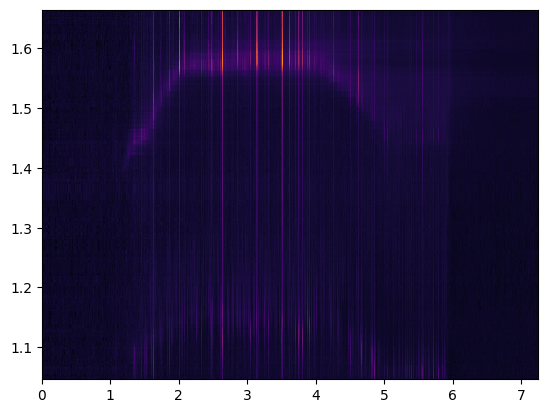

In [21]:
plt.pcolormesh(t_ir_edges, pos_ir_edges, x_ir.T, cmap='inferno')

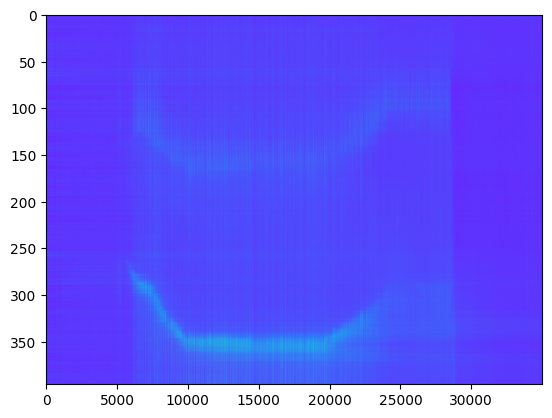

In [20]:
plt.imshow(x_ir.T, aspect='auto', cmap='rainbow')
plt.show()

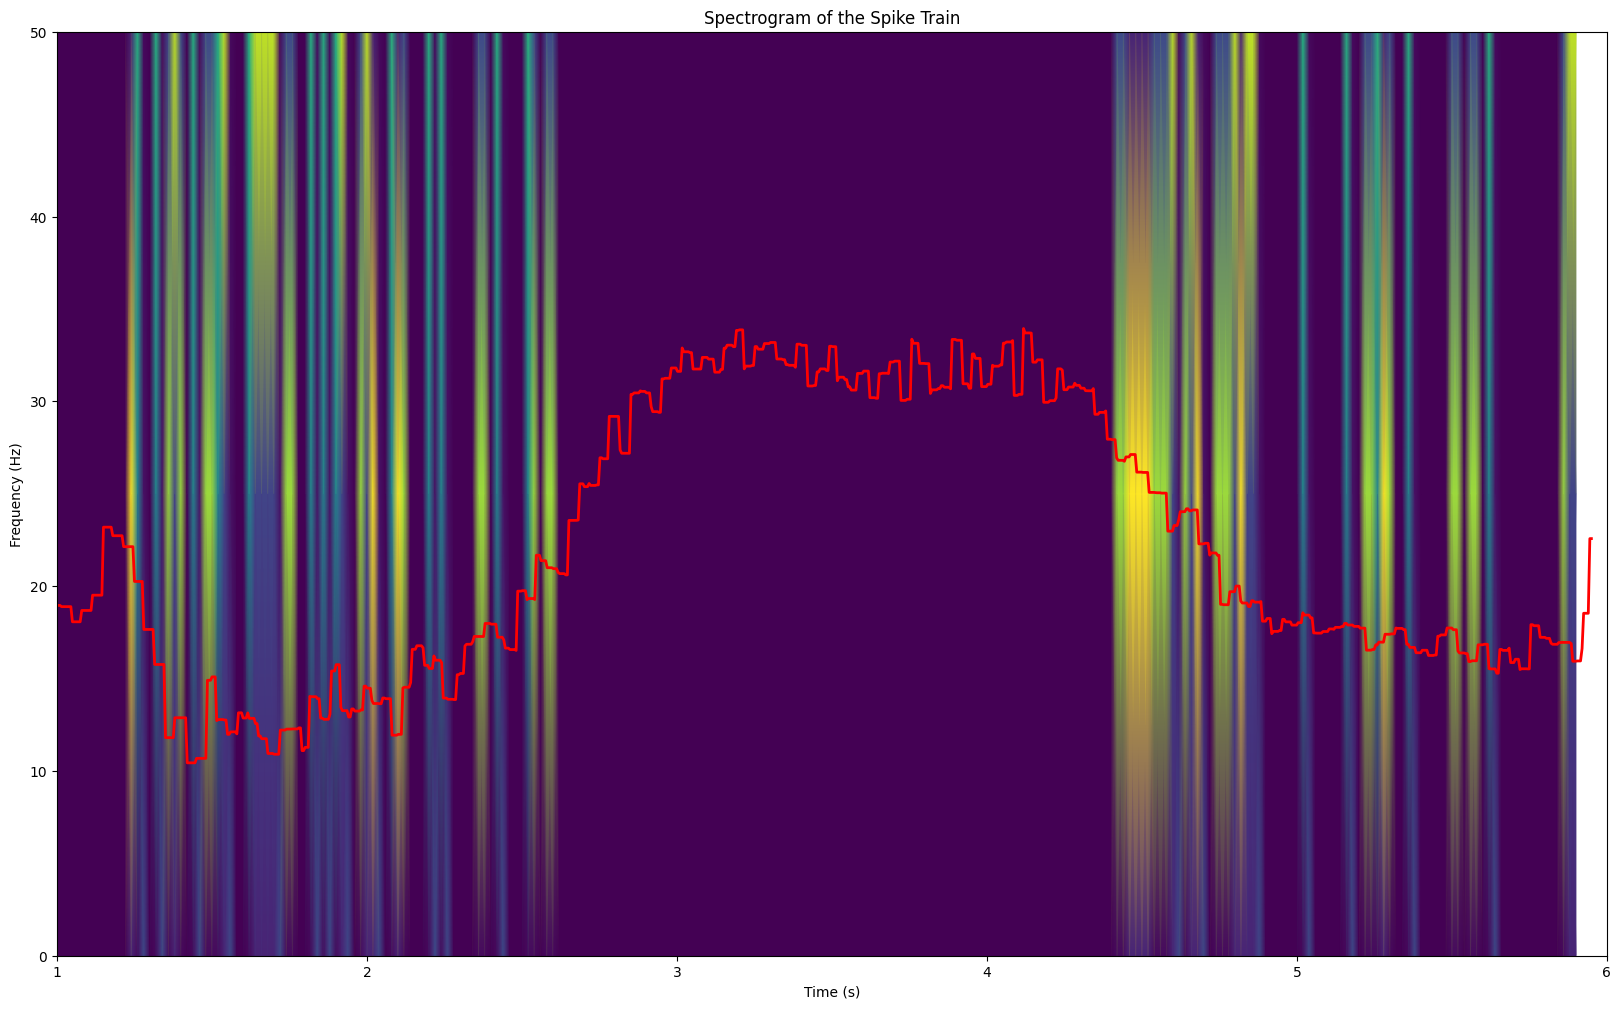

In [1120]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# -----------------------------
# 1. Prepare the spike train
# -----------------------------
# Assume spikes is a 1D numpy array of spike timestamps (in seconds). For example:
# spikes = np.array([0.1, 0.15, 0.3, 0.8, 1.2, 1.4, 1.6, 2.1, ...])
# (Replace the example below with your actual data)

# Choose a sampling rate for the binned spike train.
# (A higher fs gives you higher time resolution; adjust as needed.)
fs = 100  # samples per second

# Determine the total duration of the recording
t_end = spikes_times[-1] + 1.0/fs
t_vec = np.arange(0, t_end, 1/fs)

# Create a binary spike train (a time series with 1's at spike times)
spike_train = np.zeros_like(t_vec)
# Convert spike times (in seconds) to indices in the time vector:
spike_indices = (spikes_times * fs).astype(int)
spike_train[spike_indices] = 1

# (Optional) You might want to smooth the spike train (for example, by convolving with a Gaussian kernel)
# to get a continuous firing rate estimate.
# Here is one way to do it:
# kernel_width = int(fs * 0.001)  # e.g. a 10 ms kernel
# gauss_kernel = signal.windows.gaussian(kernel_width, std=fs * 0.002)
# gauss_kernel /= np.sum(gauss_kernel)  # normalize the kernel
# smoothed_spike_train = np.convolve(spike_train, gauss_kernel, mode='same')

# -----------------------------
# 2. Compute the spectrogram
# -----------------------------
# You can use the raw (binary) spike train or the smoothed one.
# Here we use the smoothed version:
f, t_spec, Sxx = signal.spectrogram(spike_train, fs, nperseg=4, noverlap=2)

# -----------------------------
# 3. Plot the 2D intensity (spectrogram) plot
# -----------------------------
plt.figure(figsize=(20, 12))
plt.pcolormesh(t_spec, f, Sxx, shading='gouraud')
plt.plot(t_grid, Dz_3*30, c='red', linestyle='-', label='MDL-B',linewidth=2)
# plt.ylim(0, 200)
plt.xlim(1,6)
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of the Spike Train')
# plt.colorbar(label='Intensity')
plt.show()

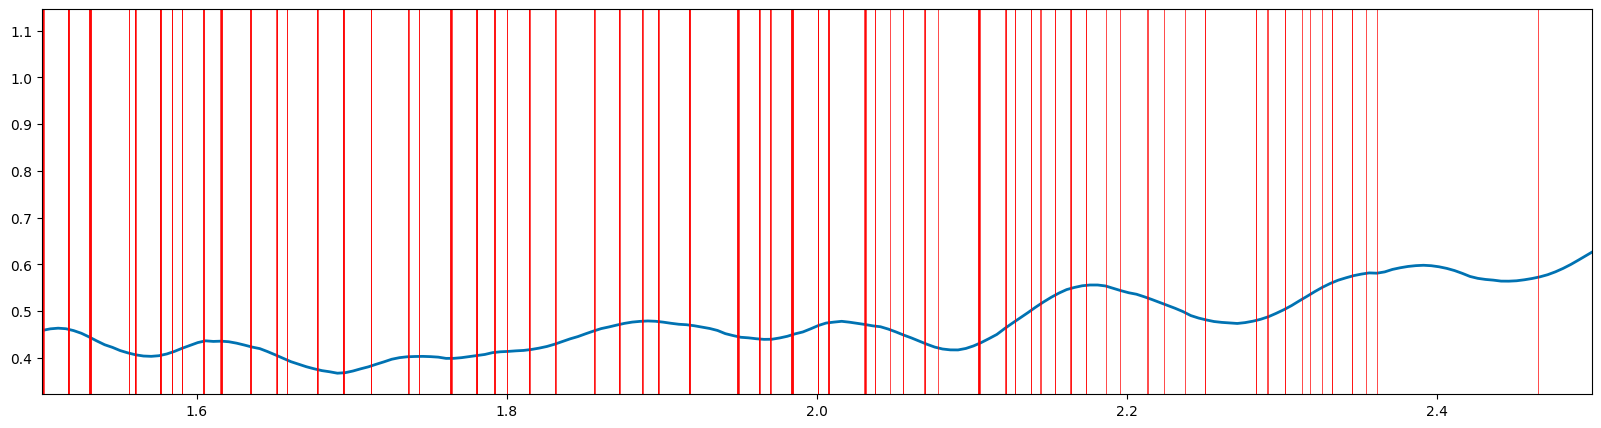

In [1110]:
plt.figure(figsize=(20,5))
plt.plot(t_grid, apply_savitzky_golay_filter(Dz_3,50,6), c=cbc_colors['bl'], linestyle='-', label='MDL-B',linewidth=2)
spikes_times_crop = spikes_times
for spike in spikes_times_crop:
    plt.axvline(spike, color='r', linewidth=0.5)
plt.xlim(1.5,2.5)
plt.show()

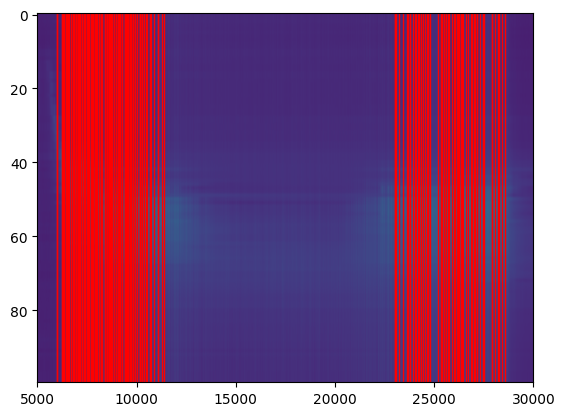

In [ ]:
plt.imshow(x_ir_crop.T, aspect='auto')

# plt.xticks(np.arange(0, x_ir.shape[0], 10000), t_ir[::10000] * 1000)
plt.xlim(5000,30000)
plt.show()

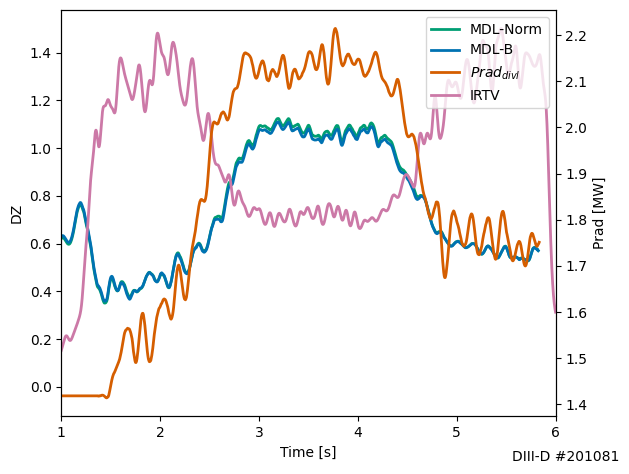

In [998]:
xptmod = (interp_RXPT[0] - 1.35)*(interp_ZXPT[0] - interp_ZStrike[0])*2.1
Dz_3 = 1 - ((interp_ZXPT - interp_prediction_2 + xptmod) / (interp_ZXPT - interp_ZStrike))[0]
fig, ax1 = plt.subplots()

# ln1 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_0/2,50,6), c=cbc_colors['pk'],alpha=0.7, linestyle='-', label='MDL-Base (/2)',linewidth=2)
# ln2 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_1,50,6), c=cbc_colors['blue'], alpha = 0.7, linestyle='-', label='MDL-Hist',linewidth=2)
ln3 = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_2,50,6), c=cbc_colors['gn'], linestyle='-', label='MDL-Norm',linewidth=2)
lnb = ax1.plot(t_grid, apply_savitzky_golay_filter(Dz_3,50,6), c=cbc_colors['bl'], linestyle='-', label='MDL-B',linewidth=2)
lnt = ax1.plot(t_ir, lowpass, c=cbc_colors['rd'], linestyle='-', label='IRTV',linewidth=2)
ax1.set_ylabel('DZ')
ax1.set_xlabel('Time [s]')
# plt.ylim(-0.05,1.3)
# for i in spikes_times:
#     plt.axvline(i, color='r')
    
plt.xlim(t_start,t_end)
# plt.vlines(spikes_times, 0, 1.3, color='r', linestyle='--')
ax2 = ax1.twinx()
lnp = ax2.plot(t_grid, apply_savitzky_golay_filter(interp_prad_divl*1e-6, 50, 6), alpha=1,label='$Prad_{divl}$', color=cbc_colors['vn'],linewidth=2)
ax2.set_ylabel('Prad [MW]')

lns = ln3 + lnb + lnp + lnt
labs = [l.get_label() for l in lns]
ax2.legend(lns, labs, loc=0)

plt.annotate(f'DIII-D #{shot}', xy=(1.13, -0.11), xycoords='axes fraction', ha='right', fontsize=10)
plt.tight_layout()
plt.savefig('../output/paper/200977_mdl.png', dpi=300)
plt.show()

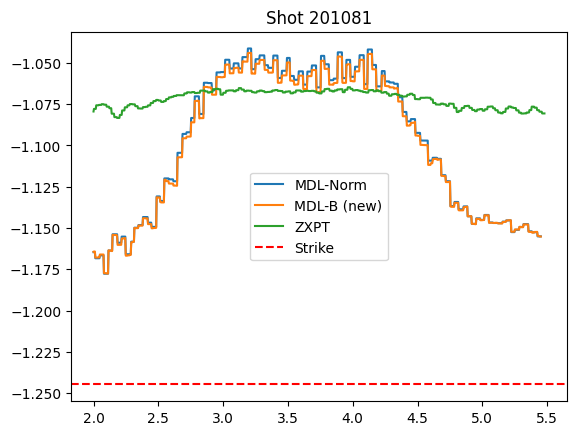

In [953]:
# plt.plot(t_grid, -1.1795 + xptmod, label='XPTMOD')
plt.title(f'Shot {shotn}')
plt.plot(t_grid, interp_prediction_2[0], label='MDL-Norm')
plt.plot(t_grid, interp_prediction_2[0] - xptmod, label='MDL-B (new)')
plt.plot(t_grid, interp_ZXPT[0], label='ZXPT')
plt.axhline(-1.24477, color='r', linestyle='--', label='Strike')
plt.legend()
plt.show()